In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import gym
import matplotlib.pyplot as plt

In [2]:
class PolicyNet(nn.Module):
    
    def __init__(self, state_dim, action_cnt):
        super().__init__()
        self.fc0 = nn.Linear(state_dim, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, action_cnt)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        p = self.softmax(x)
        return p

In [3]:
class VNet(nn.Module):
    
    def __init__(self, state_dim):
        super().__init__()
        self.fc0 = nn.Linear(state_dim, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc0(x))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [4]:
class Args:
    
    def __init__(self, gamma=0.99, max_ep=1000, p_lr=1e-3, v_lr=1e-3, eval_interval=20, eval_average=10, baseline=True):
        self.gamma = gamma
        self.max_ep = max_ep
        self.p_lr = p_lr
        self.v_lr = v_lr
        self.eval_interval = eval_interval
        self.eval_average = eval_average
        self.with_baseline = baseline

In [5]:
class PGAgent(object):
    
    def __init__(self, args: Args):
        self._args = args
        self._env = gym.make('CartPole-v0')
        self._eval_env = gym.make('CartPole-v0')
        self._state_dim = self._env.observation_space.shape[0]
        self._action_cnt = self._env.action_space.n
        self._pnet = PolicyNet(self._state_dim, self._action_cnt)
        self._vnet = VNet(self._state_dim)
        self._p_optimizer = optim.Adam(self._pnet.parameters(), lr=self._args.p_lr)
        self._v_optimizer = optim.Adam(self._vnet.parameters(), lr=self._args.v_lr)
        
    def choose_action(self, state):
        s = torch.tensor(state).float()
        with torch.no_grad():
            pi = self._pnet(s)
            dist = Categorical(pi)
            action = dist.sample()
        return action.numpy()
    
    def _calc_returns(self, rewards):
        n = len(rewards)
        g = np.zeros((n, ), dtype='float')
        for i in range(n - 2, -1, -1):
            g[i] = self._args.gamma * g[i + 1] + rewards[i]
        return g
    
    def _gen_tr(self):
        # ret: (states, actions, r)
        states = []
        actions = []
        rewards = []
        s = self._env.reset()
        done = False
        while not done:
            a = self.choose_action(s)
            s_, r, done, _ = self._env.step(a)
            states.append(s)
            actions.append(a)
            rewards.append(r)
            s = s_
        return np.array(states), np.array(actions), self._calc_returns(rewards)
    
    def _eval(self):
        s = self._eval_env.reset()
        done = False
        total = 0
        while not done:
            a = self.choose_action(s)
            s_, r, done, _ = self._eval_env.step(a)
            total += r
            s = s_
        return total
    
    def _update(self, states, actions, returns):
        s_tensor = torch.tensor(states).float()
        a_tensor = torch.tensor(actions).float()
        r_tensor = torch.tensor(returns).float()
        
        # update V
        v_output = self._vnet(s_tensor).view(-1)
        loss = torch.nn.MSELoss()(v_output, r_tensor)
        self._v_optimizer.zero_grad()
        loss.backward()
        self._v_optimizer.step()
        
        if self._args.with_baseline:
            with torch.no_grad():
                # add baseline
                r_tensor -= v_output
        
        # update policy by policy gradient
        dist = Categorical(self._pnet(s_tensor))
        logits = dist.log_prob(a_tensor)
        loss = -(logits * r_tensor).mean()

        self._p_optimizer.zero_grad()
        loss.backward()
        self._p_optimizer.step()
    
    def train(self):
        eval_eps = []
        eval_rewards = []
        for ep in range(self._args.max_ep + 1):
            states, actions, returns = self._gen_tr()
            self._update(states, actions, returns)
            if ep % self._args.eval_interval == 0:
                v = np.mean([self._eval() for _ in range(self._args.eval_average)])
                eval_eps.append(ep)
                eval_rewards.append(v)
        return eval_eps, eval_rewards

In [6]:
ep, r_with_baseline, r_without_baseline = None, None, None

args_baseline = Args(baseline=True)
agent_baseline = PGAgent(args_baseline)
ep, r_with_baseline = agent_baseline.train()

args_no_baseline = Args(baseline=False)
agent_no_baseline = PGAgent(args_no_baseline)
ep, r_without_baseline = agent_no_baseline.train()

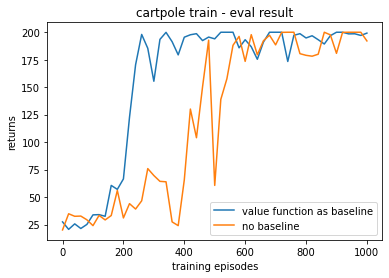

In [7]:
plt.plot(ep, r_with_baseline, label='value function as baseline')
plt.plot(ep, r_without_baseline, label='no baseline')
plt.legend()
plt.title('cartpole train - eval result')
plt.xlabel('training episodes')
plt.ylabel('returns')
plt.show()